# The thermodynamics of ideal solutions

*Authors: Enze Chen (University of California, Berkeley)*

This animation will show how the Gibbs free energy curves correspond to a lens phase diagram.

## Python imports

In [1]:
# General libraries
import io
import os

# Scientific computing libraries
import numpy as np
from scipy.misc import derivative
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation
from PIL import Image
import cv2
from moviepy.editor import *

### Helper functions

In [2]:
# analytical function for the solid free energy curve
def curve_s(x, T, beta=0):
    """This function plots the Gibbs free energy curve for the solid solution.
    
    Args:
        x (numpy.ndarray): An array of atomic fractions of B.
        T (float): The temperature in Kelvin.
        beta (float): The interaction parameter in J/mol.
        
    Returns:
        G_s (numpy.ndarray): An array of Gibbs free energy values in kJ/mol.    
    """
    S_mix = -8.314 * (np.multiply(x, np.log(x)) + np.multiply(1 - x, np.log(1 - x)))
    H_mix = beta * np.multiply(x, 1 - x)
    G_s = -T * S_mix + H_mix
    return G_s / 1000

# analytical function for the liquid free energy curve
def curve_l(x, T, beta=0):
    """This function plots the Gibbs free energy curve for the liquid solution.
    
    Args:
        x (numpy.ndarray): An array of atomic fractions of B.
        T (float): The temperature in Kelvin.
        beta (float): The interaction parameter in J/mol.
        
    Returns:
        G_l (numpy.ndarray): An array of Gibbs free energy values in kJ/mol.    
    """
    S_A, S_B = (52.7, 59.9)
    T_A, T_B = (1890 + 273, 1205 + 273)
    G_A = S_A * (T_A - T)
    G_B = S_B * (T_B - T)
    S_mix = -8.314 * (np.multiply(x, np.log(x)) + np.multiply(1 - x, np.log(1 - x)))
    H_mix = beta * np.multiply(x, 1 - x)
    G_l = x * G_B + (1 - x) * G_A - T * S_mix + H_mix
    return G_l / 1000

In [3]:
# find the common tangent using intersections and line search
def common_tangent(x, y1, y2, T, beta=0):
    """This function calculates the common tangent of two convex curves.
    
    Args:
        x (numpy.ndarray): An array of atomic fractions of B.
        y1 (numpy.ndarray): y values for curve 1.
        y2 (numpy.ndarray): y values for curve 2.
        T (float): The temperature in Kelvin.
        beta (float): The interaction parameter for the solid solution.
        
    Returns:
        line (numpy.ndarray): y values for the common tangent.
        idmin (int): Index of the x-coordinate of the first tangent point.
        idmax (int): Index of the x-coordinate of the second tangent point.
    """
    # Compute a derivative
    dx = 1e-3
    dy1 = derivative(func=curve_s, x0=x, dx=dx, args=(T, beta,))

    # Make an initial guess at the minimum of curve 1
    n = len(x)
    idmin, idmax = (0, n)
    idx = np.argmin(y1)
    yp = y1[idx]
    xp = x[idx]
    dyp = dy1[idx]

    # Construct the tangent line and count intersections with curve 2
    line = dyp * x + yp - dyp * xp
    diff = np.diff(np.sign(y2 - line))
    nnz = np.count_nonzero(diff)

    # They're the same curve. Used for finding miscibility gap.
    # I'm assuming that the curve is symmetric
    if np.linalg.norm(y1 - y2) < 1e-4:
        idmin = np.argmin(y1[:int(n/2)])
        idmax = np.argmin(y1[int(n/2):]) + int(n/2)

    # If the tangent line intersects curve 2, shift tangent point to the left
    elif nnz >= 1:
        while nnz >= 1:
            idx -= 1
            # try-except to avoid an out-of-bounds error 
            try:
                yp = y1[idx]
                xp = x[idx]
                dyp = dy1[idx]
                line = dyp * x + yp - dyp * xp
                diff = np.diff(np.sign(y2 - line))
                nnz = np.count_nonzero(diff)
            except:
                break
            if diff.any():
                # Assign left and right indices of the tangent points
                # Here we do it each time because once we miss, we can't go back
                idmax = np.nonzero(diff)[0][0]
        idmin = idx

    # If the tangent line misses curve 2, shift tangent point to the right
    elif nnz < 1:
        while nnz < 1:
            idx += 1
            # try-except to avoid an out-of-bounds error 
            try:
                yp = y1[idx]
                xp = x[idx]
                dyp = dy1[idx]
                line = dyp * x + yp - dyp * xp
                diff = np.diff(np.sign(y2 - line))
                nnz = np.count_nonzero(diff)
            except:
                break
        # Assign left and right indices of the tangent points
        idmin = idx
        idmax = np.nonzero(diff)[0][0]
    
    # Return a tuple
    return (line, idmin, idmax)

In [4]:
# plot the Gibbs free energy curves
def plot_Gx(T=1800, beta_s=0, beta_l=0):
    """This function is called by the widget to perform the plotting based on inputs.
    
    Args:
        T (float): The temperature in Kelvin.
        beta_s (float): The interaction parameter for solids in J/mol.
        beta_l (float): The interaction parameter for liquids in J/mol.
        
    Returns:
        None, but a pyplot is displayed.
    """
    # For the given temperature, calculate the curves and common tangent
    n = int(1e4)
    xmin, xmax = (0.001, 0.999)
    x = np.linspace(xmin, xmax, n)
    y_s = curve_s(x, T, beta_s)
    y_l = curve_l(x, T, beta_l)
    line, idmin, idmax = common_tangent(x, y_s, y_l, T, beta_s)

    # Mostly plot settings for visual appeal
    plt.rcParams.update({'figure.figsize':(8,6), 'font.size':20, \
                         'lines.linewidth':4, 'axes.linewidth':2})
    fig, ax = plt.subplots()
    ymin, ymax = (-39, 19)
    ax.plot(x, y_s, c='C0', label='solid')
    ax.plot(x, y_l, c='C1', label='liquid')
    if abs(idmin) < n and abs(idmax) < n:
        ax.plot(x[idmin:idmax], line[idmin:idmax], c='k', lw=5, ls='-.')
        ax.vlines(x=[x[idmin], x[idmax]], ymin=ymin, \
                  ymax=[line[idmin], line[idmax]], linestyles='dotted', linewidth=3)
    ax.tick_params(top=True, right=True, direction='in', length=10, width=2)
    ax.set_xlim(0, 1)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(r'$x_{B}$')
    ax.set_ylabel(r'$\Delta G$ (kJ/mol)')
    ax.set_title('Gibbs free energy at T = {} K'.format(T), fontsize=18)
    plt.legend()
    plt.show()

## Animations using `FuncAnimation`

Finally!! VLC/Windows has buggy glitches, but the embedded HTML version looks fine.
Also, **extremely high quality and low memory footprint**!! 🎉

1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


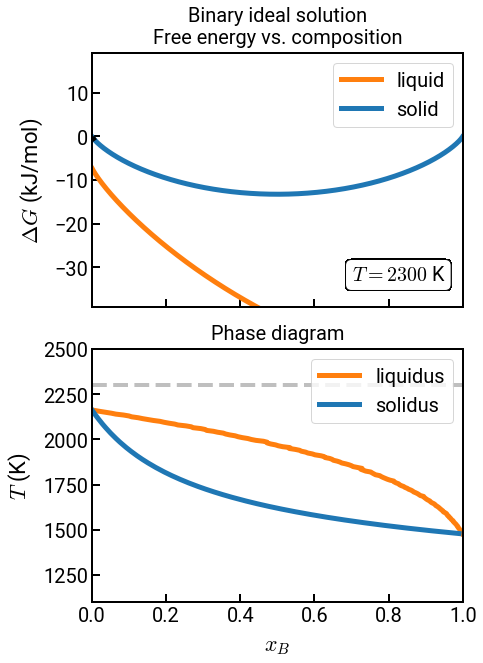

In [5]:
# Initialize quantities
n = int(1e4)
xmin, xmax = (0.001, 0.999)
x = np.linspace(xmin, xmax, n)
liquidus = []
solidus = []
Ts = np.arange(1300, 2301, 5)

# Plot settings
plt.rcParams.update({'figure.figsize':(7,9.5), 'font.size':16})
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

# Initialize plot settings
ymin, ymax = -39, 19
ax[0].set_xlim(0, 1)
ax[0].set_ylim(ymin, ymax)
ax[0].set_ylabel(r'$\Delta G$ (kJ/mol)', fontsize=22)
ax[0].set_title('Binary ideal solution\nFree energy vs. composition', fontsize=20)
ax[0].tick_params(axis='both', labelsize=20)

Tmin, Tmax = 1100, 2500
ax[1].set_xlabel(r'$x_{B}$', fontsize=22)
ax[1].set_ylabel(r'$T$ (K)', fontsize=22)
ax[1].set_ylim(Tmin, Tmax)
ax[1].set_title('Phase diagram', fontsize=20)
ax[1].tick_params(axis='both', labelsize=20)

# Initialize the lines
l1, = ax[0].plot([], [], c='C1', label='liquid')
l2, = ax[0].plot([], [], c='C0', label='solid')
l3, = ax[1].plot([], [], c='C1', label='liquidus')
l4, = ax[1].plot([], [], c='C0', label='solidus')
l5, = ax[1].plot([], [], c='gray', ls='dashed', lw=4, alpha=0.5, zorder=-5)
v3, = ax[0].plot([], [], c='k', ls='-.')
v1 = ax[0].vlines(x=[0], ymin=[0], ymax=[0], linestyles='dotted', linewidth=4, color='k')
v2 = ax[1].vlines(x=[0], ymin=[0], ymax=[0], linestyles='dotted', linewidth=4, color='k')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
plt.tight_layout()

# This is needed to avoid an extra loop
def init():
    l1.set_data([], [])
    return l1,

# This does the enumeration
def animate(i):
    global ymin, ymax, Tmax, liquidus, solidus, x, n, Ts, v1, v2
    T = Ts[i]
    if T % 100 == 0:
        print(T)
    y_s = curve_s(x, T)
    y_l = curve_l(x, T)
    line, idmin, idmax = common_tangent(x, y_s, y_l, T)   # compute common tangent
    if idmin == 0 or idmin == n-1 or idmax == 0 or idmax == n-1:
        liquidus.append(None)
        solidus.append(None)
    else:
        liquidus.append(x[idmax])
        solidus.append(x[idmin])

    # set the data to be updated each iteration
    l1.set_data(x, y_l)
    l2.set_data(x, y_s)
    l3.set_data(liquidus, Ts[:np.where(Ts==T)[0][0]+1])
    l4.set_data(solidus, Ts[:np.where(Ts==T)[0][0]+1])
    l5.set_data([0, 1], [T, T])
    ax[0].annotate(text=f'$T={T}$ K', xy=(0.70, -33), fontsize=20, 
                   bbox=dict(fc='1.0', boxstyle='round'))
    
    # handle the tangent points
    if T == 2170:
        v1.remove()
        v2.remove()
    if abs(idmin) < n and abs(idmax) < n and idmax != 0:
        v1.remove()
        v2.remove()
        v3.set_data(x[idmin:idmax], line[idmin:idmax])
        v1 = ax[0].vlines(x=[x[idmin], x[idmax]], ymin=ymin, \
                  ymax=[line[idmin], line[idmax]], linestyles='dotted', linewidth=4, colors=['C0', 'C1'])
        v2 = ax[1].vlines(x=[x[idmin], x[idmax]], ymin=T, ymax=Tmax, linestyles='dotted', linewidth=4, colors=['C0', 'C1'])
        
    # return the artists that get updated (for blitting)
    return l1, l2, l3, l4, l5, v3, v2, v1

# Create animation object
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(Ts), interval=1000, blit=True, repeat=False)

# Save animation as MP4 (preferred)
# anim.save('C:/Users/Enze/Desktop/test_funcanim.mp4', fps=9, dpi=300, writer='ffmpeg')
# Save animation as GIF (file size MUCH larger!)
# anim.save('C:/Users/Enze/Desktop/test_funcanim.gif', fps=9, dpi=300, writer='pillow')   

plt.show()

## Other (sub-par) methods that I've tried...

In [ ]:
# Accumulate images in a list for post-processing
n = int(1e4)
xmin, xmax = (0.001, 0.999)
x = np.linspace(xmin, xmax, n)
liquidus = []
solidus = []
Ts = np.arange(1300, 1450, 10)

plt.rcParams.update({'figure.figsize':(7,9)})
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.tight_layout()
ymin, ymax = -39, 19
ax[0].set_xlim(0, 1)
ax[0].set_ylim(ymin, ymax)
ax[0].set_ylabel(r'$\Delta G$ (kJ/mol)')

Tmin, Tmax = 1100, 2500
ax[1].set_xlabel(r'$x_{B}$')
ax[1].set_ylabel(r'$T$ (K)')
ax[1].set_ylim(Tmin, Tmax)
images = []

for i,T in enumerate(Ts):
    if T % 100 == 0:
        print(T)
    y_s = curve_s(x, T)
    y_l = curve_l(x, T)
    line, idmin, idmax = common_tangent(x, y_s, y_l, T)
    if idmin == 0 or idmin == n-1 or idmax == 0 or idmax == n-1:
        liquidus.append(None)
        solidus.append(None)
    else:
        liquidus.append(x[idmax])
        solidus.append(x[idmin])

    ax[0].plot(x, y_s, c='C0', label='solid')
    ax[0].plot(x, y_l, c='C1', label='liquid')
    if abs(idmin) < n and abs(idmax) < n and idmax != 0:
        ax[0].plot(x[idmin:idmax], line[idmin:idmax], c='k', ls='-.')
        v1 = ax[0].vlines(x=[x[idmin], x[idmax]], ymin=ymin, \
                  ymax=[line[idmin], line[idmax]], linestyles='dotted', linewidth=4, color='k')
        v2 = ax[1].vlines(x=[x[idmin], x[idmax]], ymin=T, ymax=Tmax, linestyles='dotted', linewidth=4, color='k')
    ax[0].legend(loc='upper right')

    ax[1].plot(liquidus, Ts[:i+1], c='C1', label='liquidus')
    ax[1].plot(solidus, Ts[:i+1], c='C0', label='solidus')
    ax[1].plot([0, 1], [T, T], c='gray', ls='dashed', lw=4, alpha=0.5, zorder=-5)
    ax[1].annotate(text=f'$T={T}$ K', xy=(0.7, 2320), fontsize=24, 
                   bbox=dict(fc='1.0', boxstyle='round'))
    
#     fig.savefig(f'C:/Users/Enze/Desktop/plots/fig_{T:4d}')
    
    # Convert to PIL image for GIF
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    images.append(Image.open(buf))

    while len(ax[0].lines) > 0:
        ax[0].lines.remove(ax[0].lines[0])
    while len(ax[1].lines) > 0:
        ax[1].lines.remove(ax[1].lines[0])
    if abs(idmin) < n and abs(idmax) < n and idmax != 0:
        v1.remove()
        v2.remove()

# Make a GIF by converting from PIL Image
make_gif = True
if make_gif:   # Quality is pretty good!!
    images[0].save('C:/Users/Enze/Desktop/test_PIL3.gif', save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)
    print('Finished making GIF')

### Convert PIL images to mp4 using [OpenCV](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html)

OK, this works! 
Quality could be improved... this is where FuncAnimation native support would probably be better.

In [26]:
# This movie is very large in size!!
opencv_images = [cv2.cvtColor(np.array(i), cv2.COLOR_RGB2BGR) for i in images]
height, width, channels = opencv_images[0].shape
fourcc = cv2.VideoWriter_fourcc(*'MP4V')   # can also be 'MJPG' or 'MP4V'
video = cv2.VideoWriter(filename='C:/Users/Enze/Desktop/test_opencv.mp4', 
                        fourcc=fourcc, fps=6, frameSize=(width, height))
for i in opencv_images:
    video.write(i)
cv2.destroyAllWindows()
video.release()

### Convert figure files using [`moviepy`](https://moviepy.readthedocs.io/en/latest/index.html)

Quality seems a little worse than OpenCV. 
Also takes a longggg time lol, but the file size is very small!

In [ ]:
datadir = 'C:/Users/Enze/Desktop/plots/'
clips = [ImageClip(os.path.join(datadir, m)).set_duration(0.2) for m in os.listdir(datadir)]
concat = concatenate_videoclips(clips, method='compose')
concat.write_videofile('C:/Users/Enze/Desktop/test_moviepy.mp4', fps=10)